In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import celloracle as co

/home/hdlab/miniconda3/envs/celloracle_env/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/hdlab/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
print(f"CellOracle version: {co.__version__}")

CellOracle version: 0.20.0


In [3]:
# Visualization settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['savefig.dpi'] = 300

# Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [4]:
save_folder = "figures"
data_folder = "processed_data"
os.makedirs(save_folder, exist_ok=True)
os.makedirs(data_folder, exist_ok=True)

### load & preprocess data

In [5]:
data_dir = "CTR9_snRNASeq"

wt_path = os.path.join(data_dir, "WT", "filtered_feature_bc_matrix.h5")
ko_path = os.path.join(data_dir, "KO", "filtered_feature_bc_matrix.h5")

print(f"WT file exists: {os.path.exists(wt_path)}")
print(f"KO file exists: {os.path.exists(ko_path)}")

WT file exists: True
KO file exists: True


In [6]:
# Load WT data
adata_wt = sc.read_10x_h5(wt_path)
adata_wt.var_names_make_unique()
adata_wt.obs['genotype'] = 'WT'
adata_wt.obs['sample'] = 'WT'
print(f"WT data shape: {adata_wt.shape}")
adata_wt

reading CTR9_snRNASeq/WT/filtered_feature_bc_matrix.h5
 (0:00:00)
WT data shape: (4981, 33696)


AnnData object with n_obs × n_vars = 4981 × 33696
    obs: 'genotype', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
# Load KO data
adata_ko = sc.read_10x_h5(ko_path)
adata_ko.var_names_make_unique()
adata_ko.obs['genotype'] = 'KO'
adata_ko.obs['sample'] = 'CTR9_KO'
print(f"KO data shape: {adata_ko.shape}")
adata_ko

reading CTR9_snRNASeq/KO/filtered_feature_bc_matrix.h5
 (0:00:00)
KO data shape: (4888, 33696)


AnnData object with n_obs × n_vars = 4888 × 33696
    obs: 'genotype', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
# Make cell barcodes unique before concatenation
adata_wt.obs_names = [f"WT_{bc}" for bc in adata_wt.obs_names]
adata_ko.obs_names = [f"KO_{bc}" for bc in adata_ko.obs_names]

In [9]:
# Concatenate datasets
adata = ad.concat([adata_wt, adata_ko], join='outer')
adata.obs_names_make_unique()
print(f"Combined data shape: {adata.shape}")
print(f"\nGenotype distribution:")
print(adata.obs['genotype'].value_counts())

Combined data shape: (9869, 33696)

Genotype distribution:
WT    4981
KO    4888
Name: genotype, dtype: int64


### standard preprocessing

... storing 'genotype' as categorical
... storing 'sample' as categorical


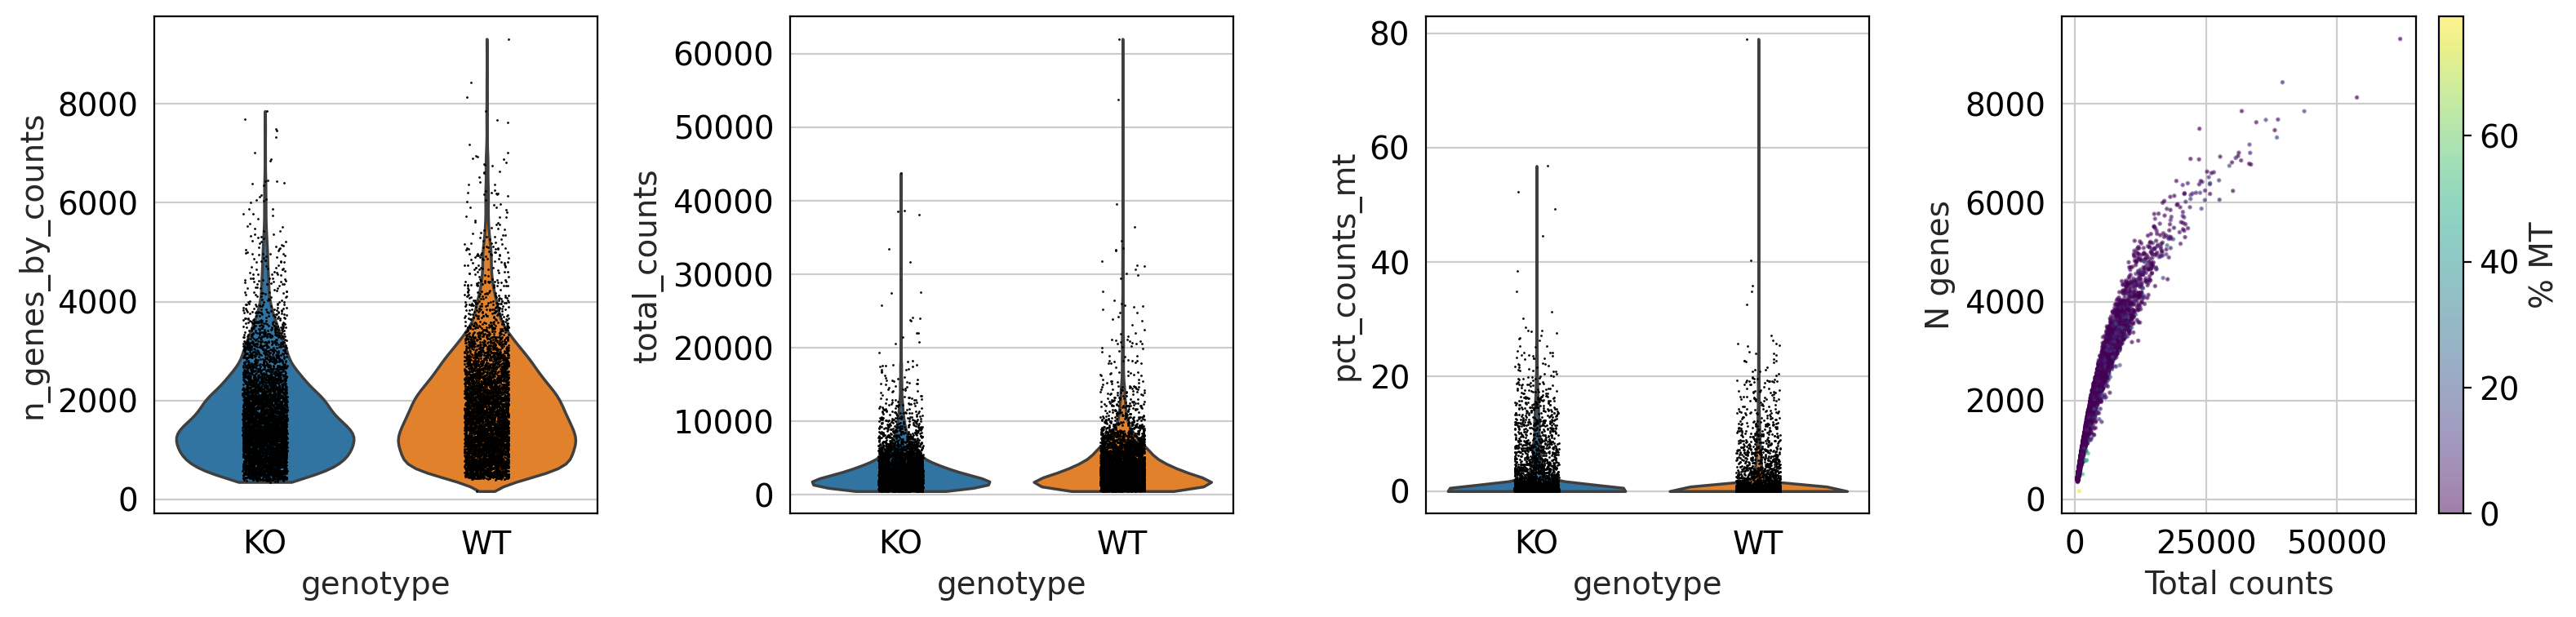

In [10]:
# Calculate QC metrics
# For mouse, mitochondrial genes start with 'mt-' (lowercase)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Visualize QC metrics
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sc.pl.violin(adata, 'n_genes_by_counts', groupby='genotype', ax=axes[0], show=False)
sc.pl.violin(adata, 'total_counts', groupby='genotype', ax=axes[1], show=False)
sc.pl.violin(adata, 'pct_counts_mt', groupby='genotype', ax=axes[2], show=False)

# Scatter plot
axes[3].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], 
                c=adata.obs['pct_counts_mt'], cmap='viridis', s=1, alpha=0.5)
axes[3].set_xlabel('Total counts')
axes[3].set_ylabel('N genes')
plt.colorbar(axes[3].collections[0], ax=axes[3], label='% MT')

plt.tight_layout()
plt.savefig(f"{save_folder}/QC_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Filter cells 
print(f"Cells before filtering: {adata.n_obs}")

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=5000)
sc.pp.filter_genes(adata, min_cells=3)

# Filter by mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < 20, :].copy()

print(f"Cells after filtering: {adata.n_obs}")
print(f"Genes after filtering: {adata.n_vars}")
print(f"\nGenotype distribution after filtering:")
print(adata.obs['genotype'].value_counts())

Cells before filtering: 9869
filtered out 1 cells that have less than 200 genes expressed
filtered out 131 cells that have more than 5000 genes expressed
filtered out 9789 genes that are detected in less than 3 cells
Cells after filtering: 9659
Genes after filtering: 23907

Genotype distribution after filtering:
WT    4873
KO    4786
Name: genotype, dtype: int64


### preprocessing for cell oracel

In [12]:
adata.layers['raw_count'] = adata.X.copy()

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of highly variable genes: 2500


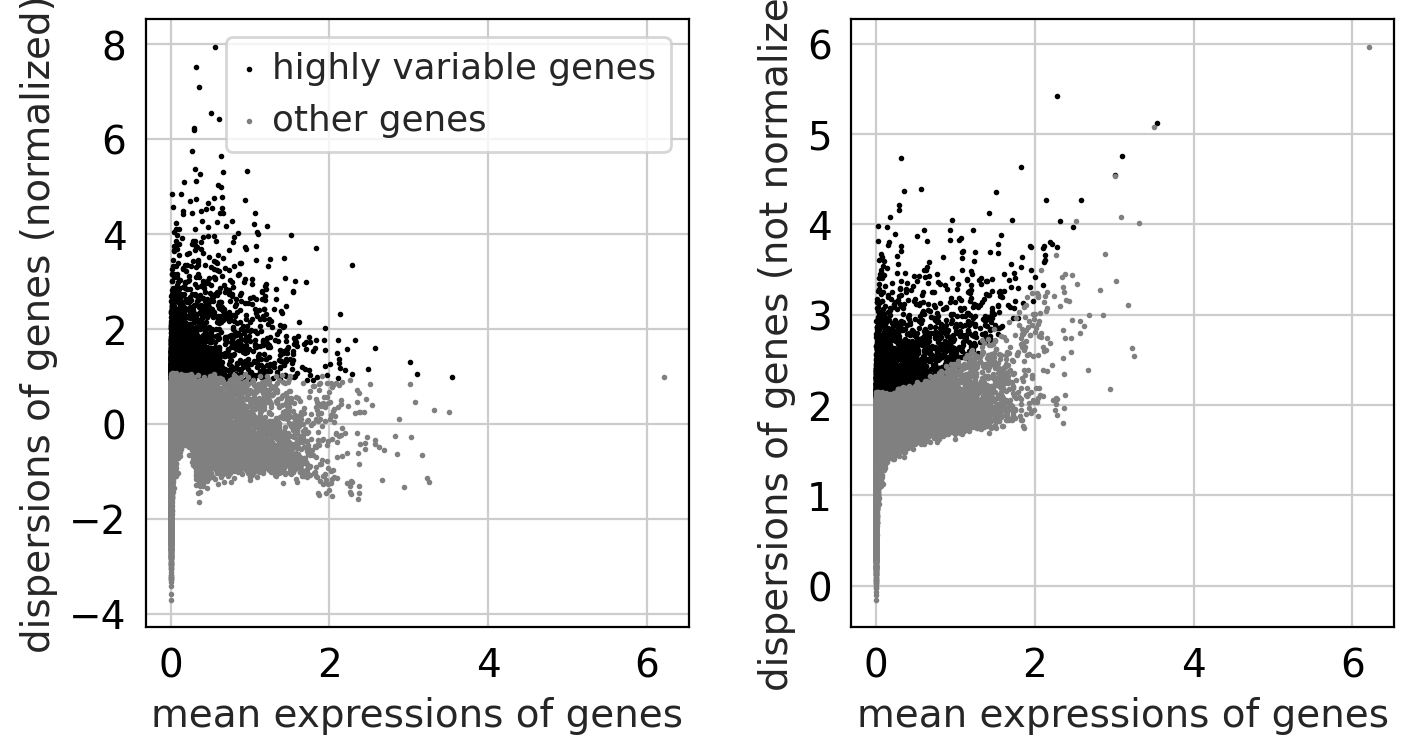

In [14]:
# Variable gene selection
# CellOracle works best with 2000-3000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2500, batch_key='genotype')
print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [15]:
# Subset to highly variable genes
adata = adata[:, adata.var['highly_variable']].copy()
print(f"Data shape after HVG selection: {adata.shape}")

Data shape after HVG selection: (9659, 2500)


In [16]:
# Scale data (for PCA/clustering, not for CellOracle GRN inference)
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    with n_comps=50
    finished (0:00:01)


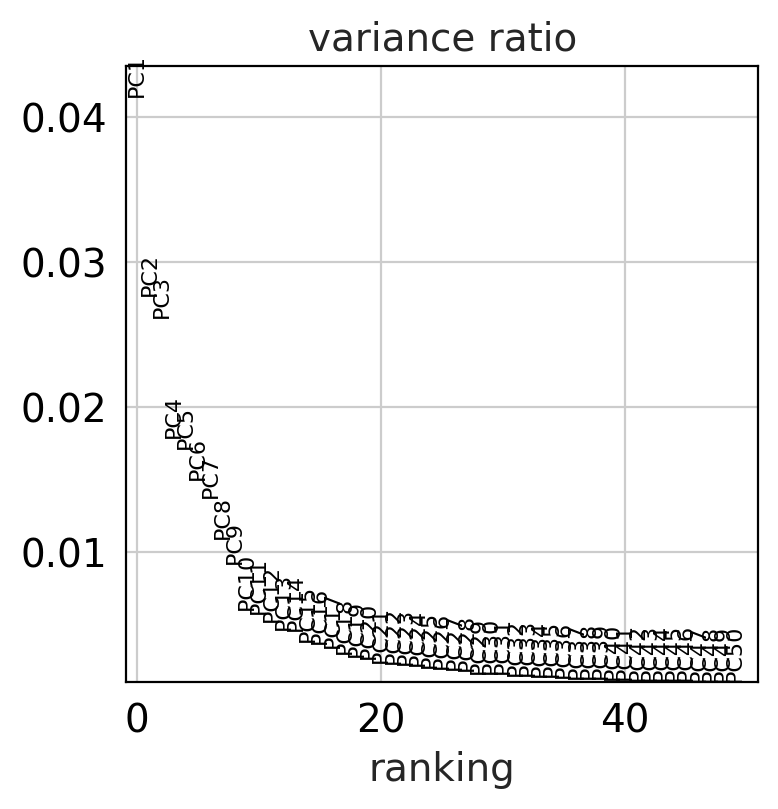

In [17]:
# PCA
sc.tl.pca(adata, n_comps=50)
sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [18]:
use_rep = 'X_pca'  # Use this if not doing integration

# Compute neighbors and UMAP
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, use_rep=use_rep)
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [19]:
# Clustering
sc.tl.leiden(adata, resolution=0.8)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


### PAGA and force directed graph embeddingg

In [20]:
# Compute diffusion map (useful for trajectory analysis)
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9948107  0.99341875 0.9930072  0.99210525 0.9912125
     0.9895131  0.9883664  0.9877483  0.9871927  0.9865094  0.98436695
     0.98371106 0.9830186  0.9821011 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [21]:
# Compute PAGA
sc.tl.paga(adata, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


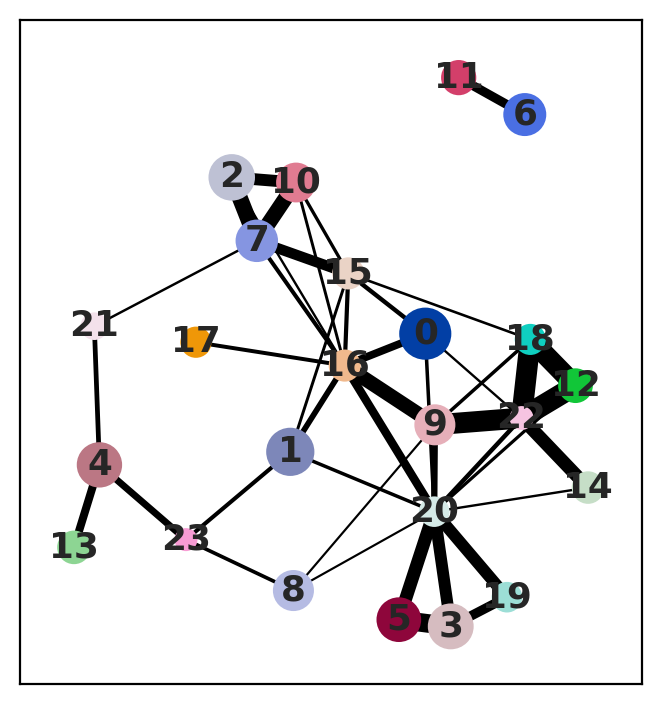

In [22]:
# Visualize PAGA graph
sc.pl.paga(adata, plot=True, threshold=0.1)

In [23]:
# Compute force-directed graph layout initialized with PAGA
# This is the preferred embedding for CellOracle
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:24)


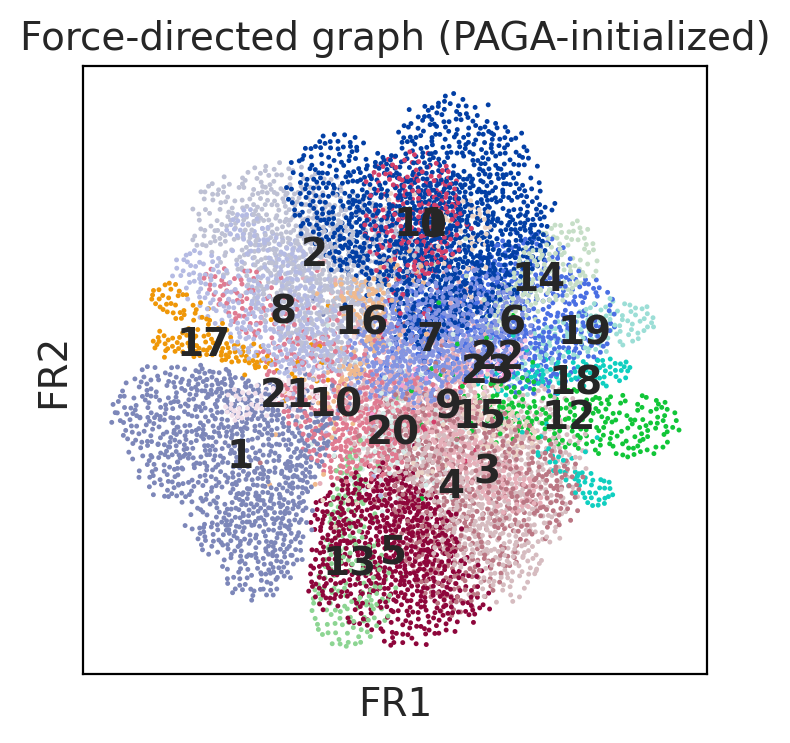

In [ ]:
# Visualize force-directed graph
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data', title='Force-directed graph (PAGA-initialized)')

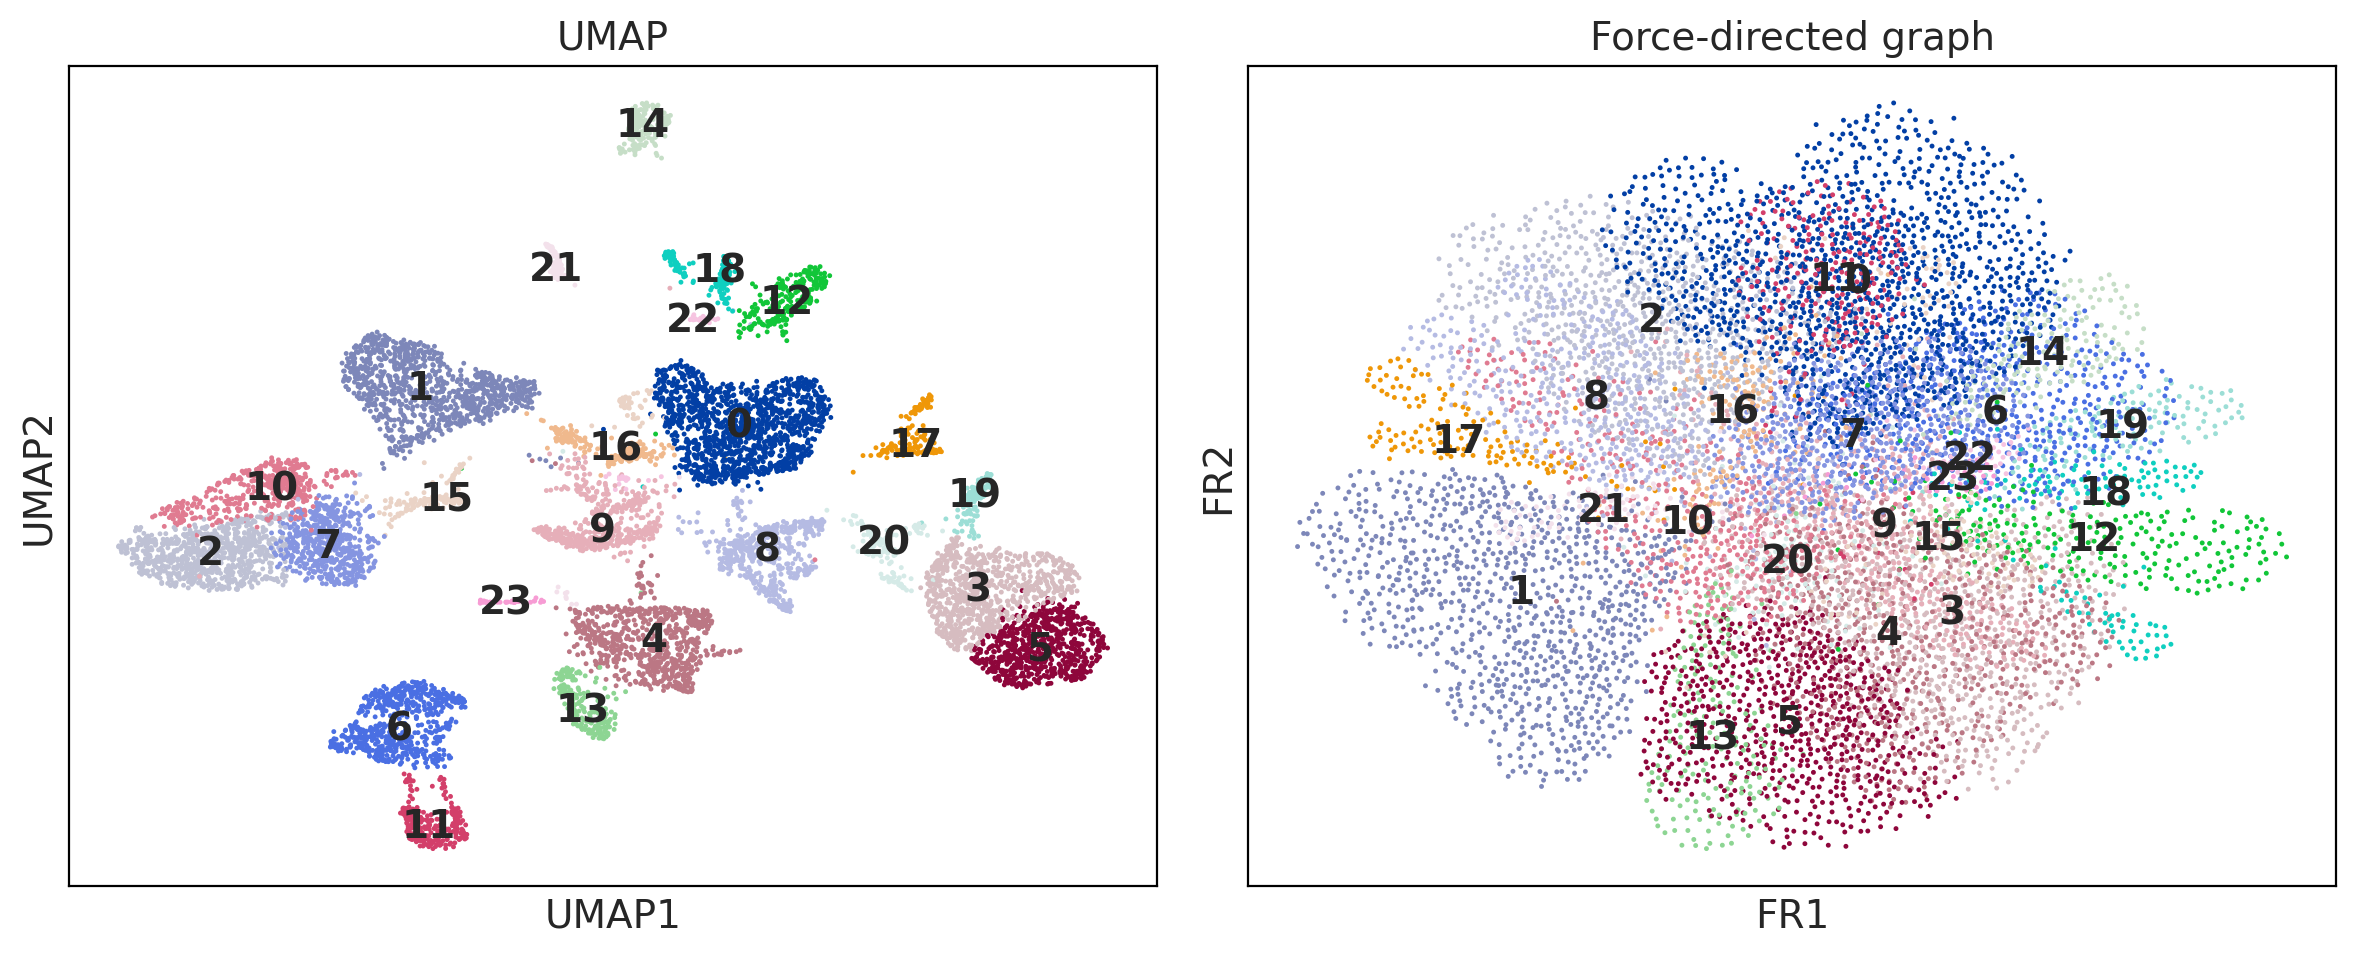

In [ ]:
# Compare embeddings: UMAP vs Force-directed graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='UMAP', legend_loc='on data')
sc.pl.draw_graph(adata, color='leiden', ax=axes[1], show=False, title='Force-directed graph', legend_loc='on data')
plt.tight_layout()
plt.savefig(f"{save_folder}/embedding_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

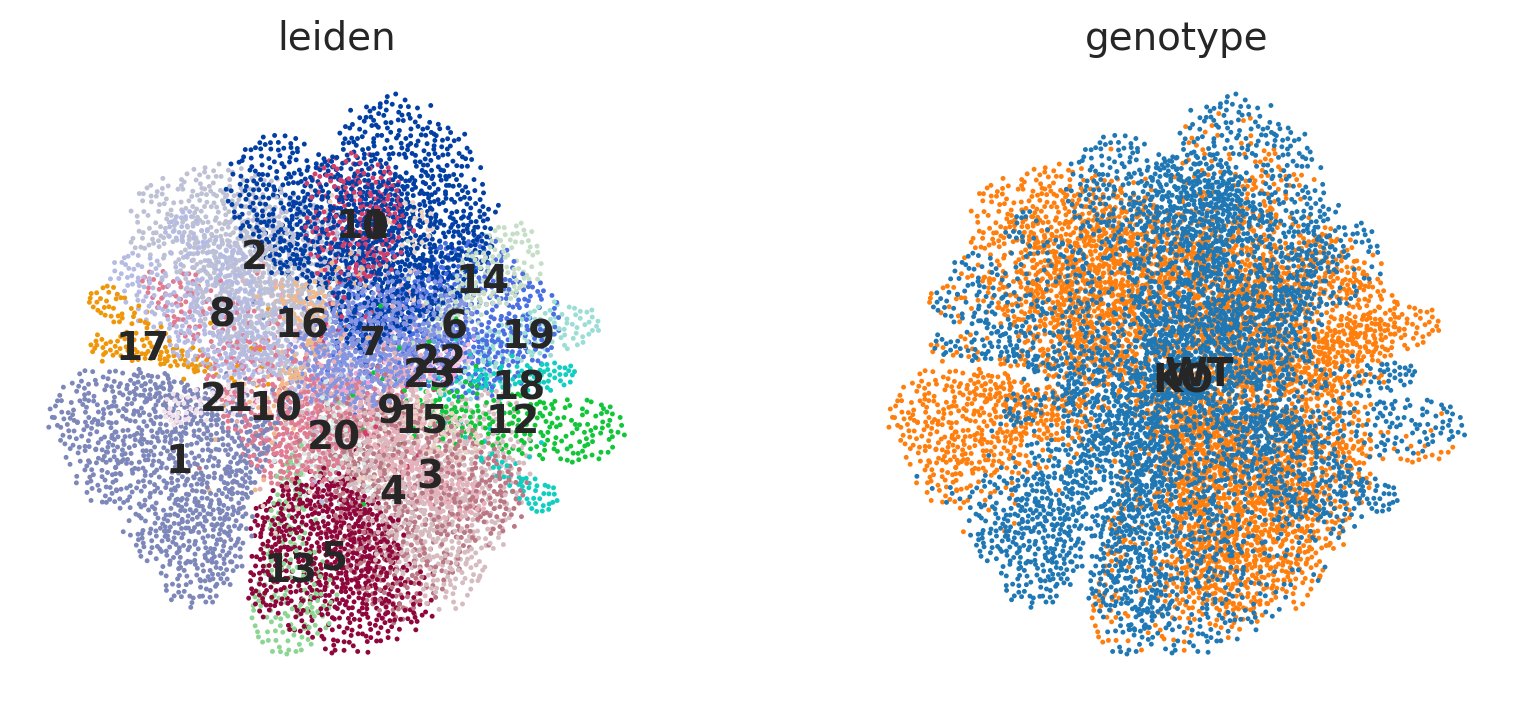

In [ ]:
# View genotype distribution on force-directed graph
sc.pl.draw_graph(adata, color=['leiden', 'genotype'], legend_loc='on data', ncols=2, frameon=False)

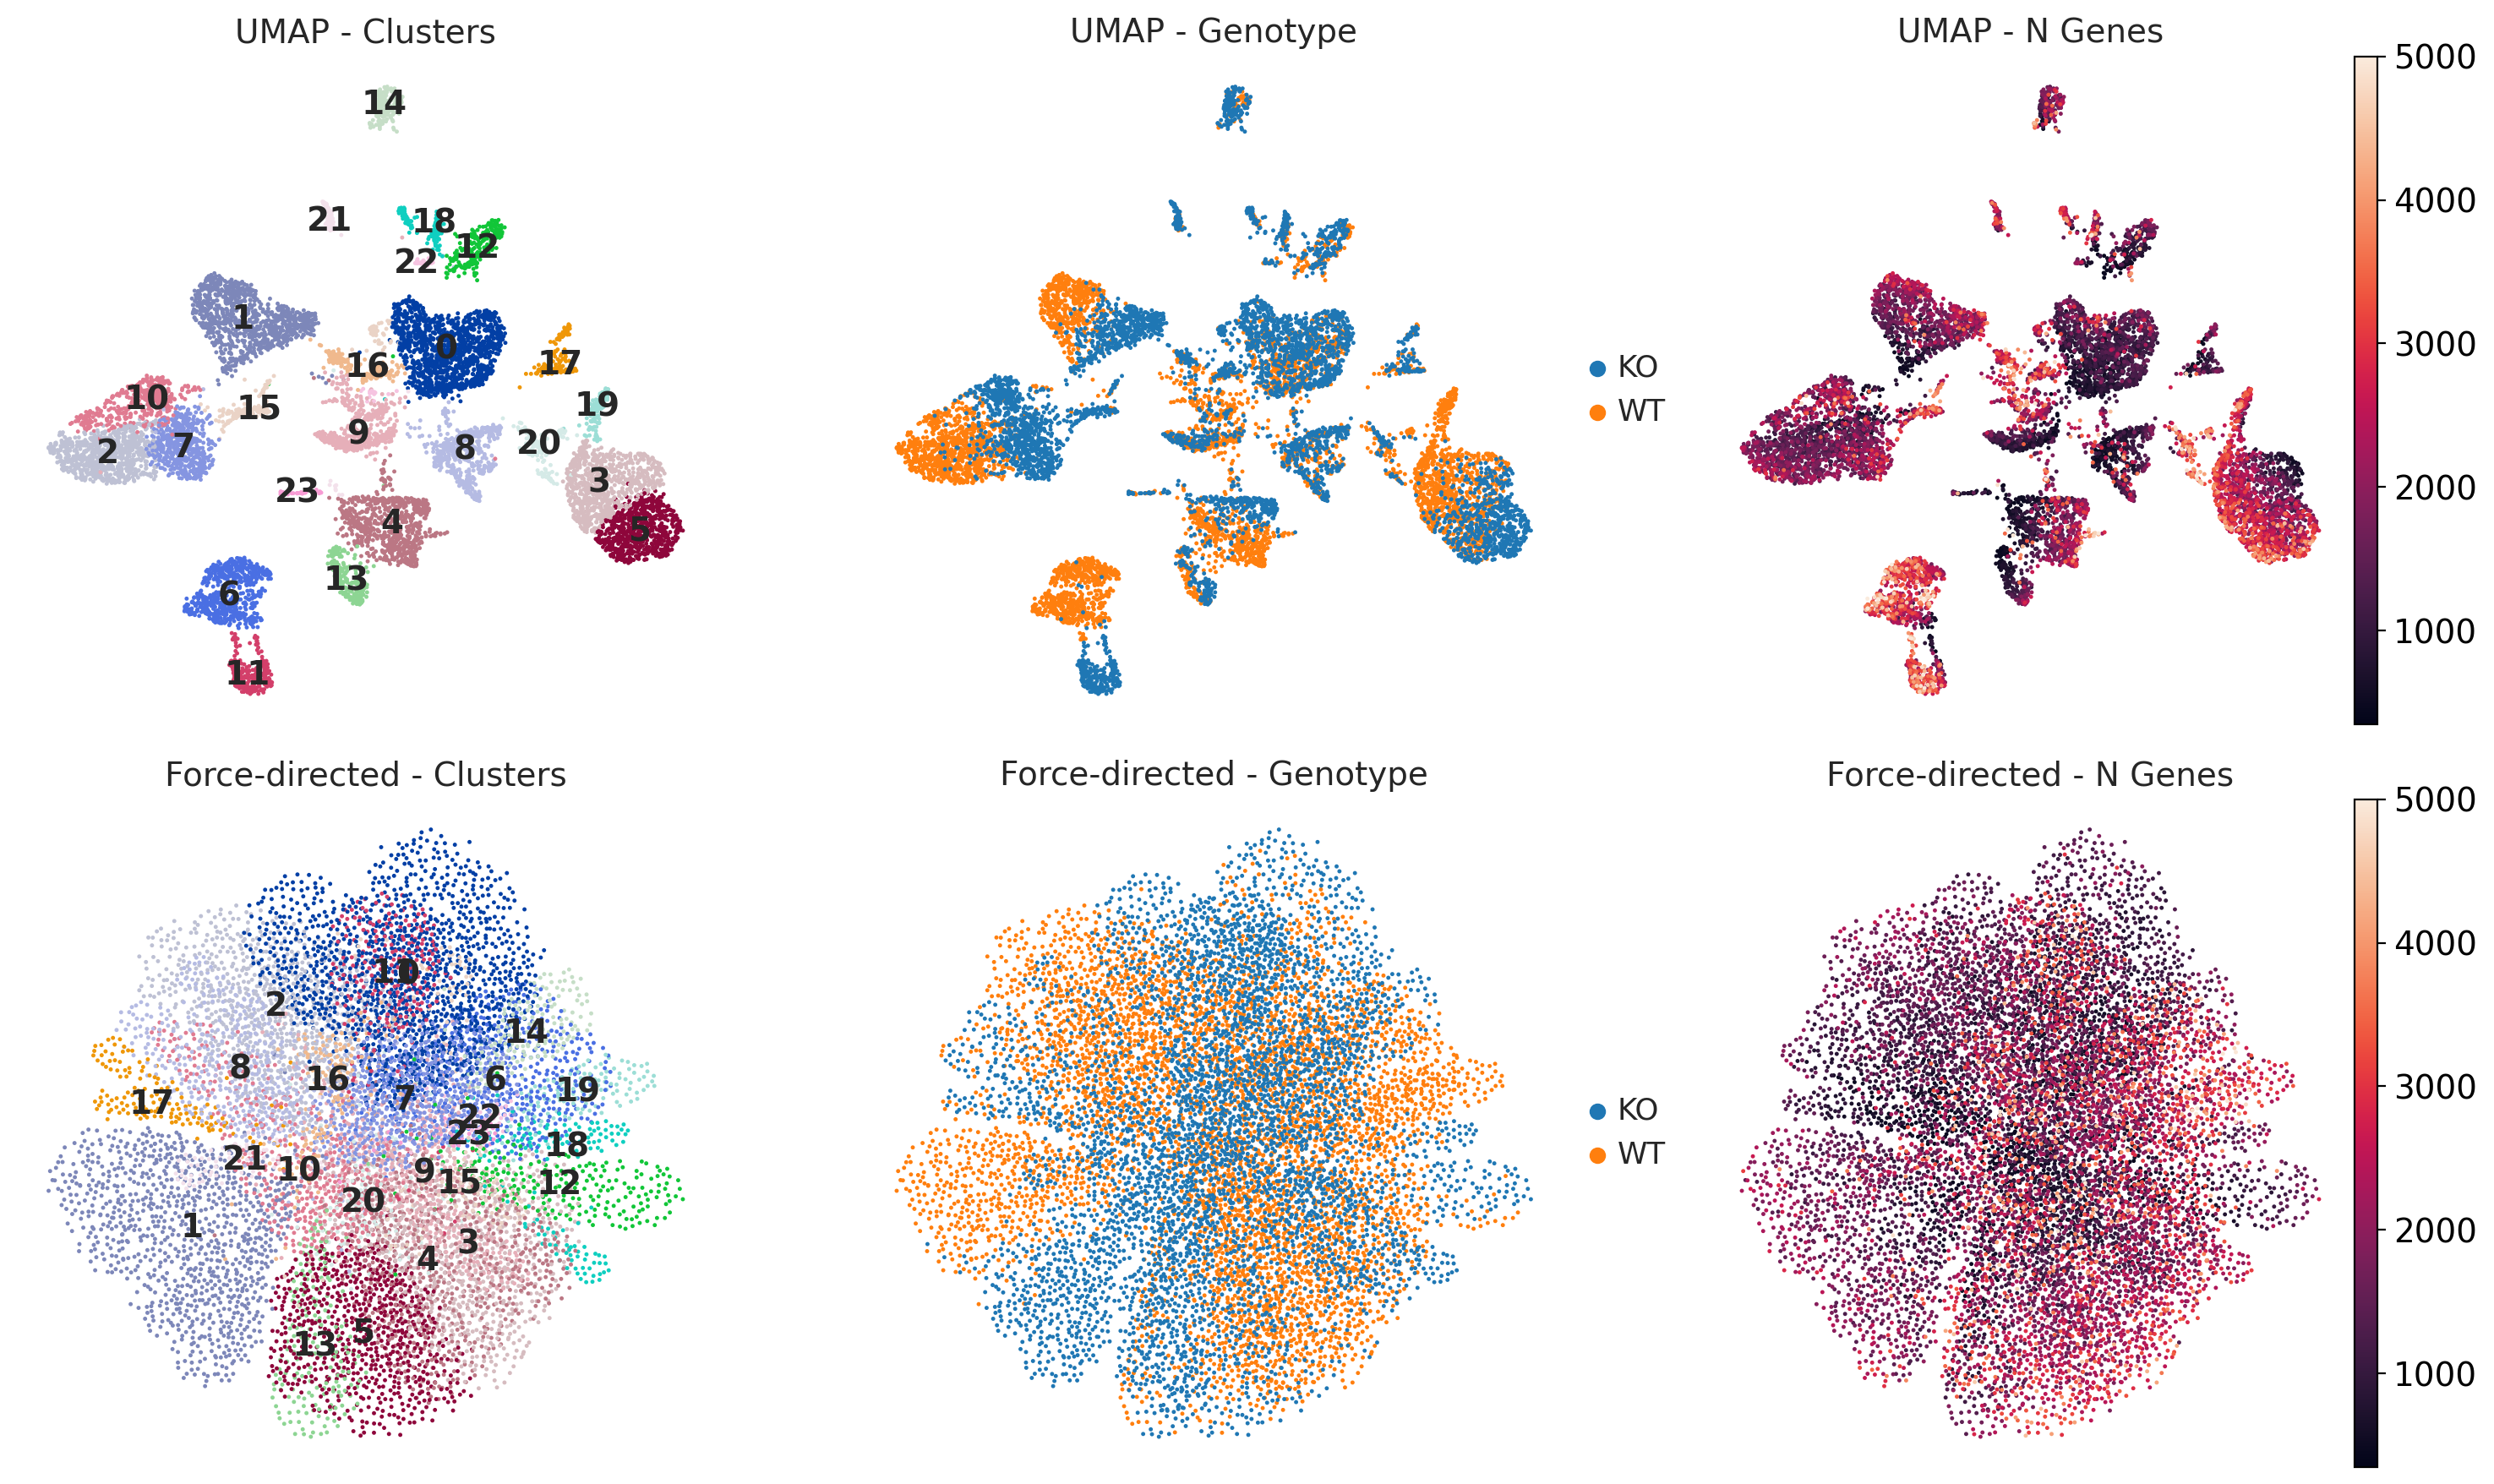

In [ ]:
# Visualize clustering and genotype
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Top row: UMAP
sc.pl.umap(adata, color='leiden', ax=axes[0, 0], show=False, legend_loc='on data', title='UMAP - Clusters', frameon=False)
sc.pl.umap(adata, color='genotype', ax=axes[0, 1], show=False, title='UMAP - Genotype', frameon=False)
sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[0, 2], show=False, title='UMAP - N Genes', frameon=False)

# Bottom row: Force-directed graph
sc.pl.draw_graph(adata, color='leiden', ax=axes[1, 0], show=False, legend_loc='on data', title='Force-directed - Clusters', frameon=False)
sc.pl.draw_graph(adata, color='genotype', ax=axes[1, 1], show=False, title='Force-directed - Genotype', frameon=False)
sc.pl.draw_graph(adata, color='n_genes_by_counts', ax=axes[1, 2], show=False, title='Force-directed - N Genes', frameon=False)

plt.tight_layout()
plt.savefig(f"{save_folder}/embeddings_overview.png", dpi=300, bbox_inches='tight')
plt.show()